In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import and_


In [20]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [21]:
# reflect an existing database into a new model
Base= automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [22]:
# View all of the classes that automap found
classes= Base.classes

#Print classes
for class_name in classes.keys():
    print(class_name)

measurement
station


In [24]:
# Save references to each table
Station= Base.classes.station
Measurement= Base.classes.measurement


In [25]:
# Create our session (link) from Python to the DB
session= Session(engine)

# Exploratory Precipitation Analysis

In [26]:
# Find the most recent date in the data set.
most_recent_date= session.query(func.Max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


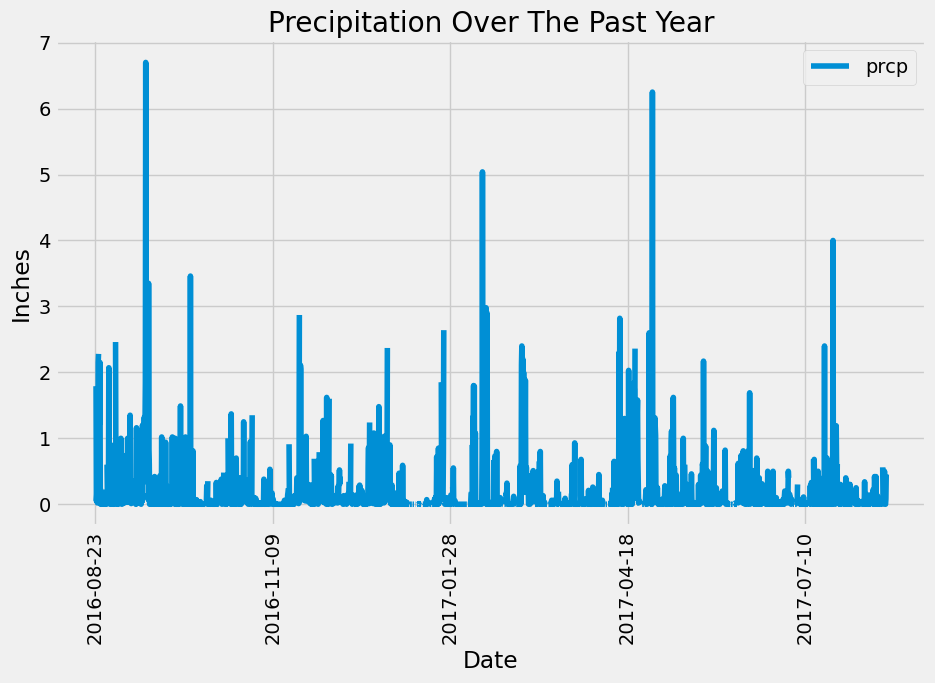

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)

# Perform a query to retrieve the data and precipitation scores
results_last_year = session.query(Measurement.date, Measurement.prcp)\
                            .filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d'), Measurement.date <= most_recent_date)\
                            .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_year_df = pd.DataFrame(results_last_year, columns=['date', 'prcp'])
last_year_df.set_index('date', inplace=True)

# Sort the dataframe by date
last_year_df= last_year_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
last_year_df.plot(y='prcp', figsize= (10, 6), legend=True)
plt.title('Precipitation Over The Past Year')
plt.xlabel ('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.show()

In [28]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_precip_stats= last_year_df.describe()
summary_precip_stats

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [29]:
# Design a query to calculate the total number of stations in the dataset
total_stations= session.query(Station).count()

#Print station totals
total_stations

9

In [30]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations= session.query(Measurement.station, func.count(Measurement.station).label('station_count'))\
                    .group_by(Measurement.station)\
                    .order_by(func.count(Measurement.station).desc())\
                    .all()

#in descending order
for station, count in most_active_stations:
    print(f'Station: {station}, Count: {count}')


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_temps = (session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp'))
    .filter(Measurement.station == 'USC00519281')
    .all())

#Store results in dataframe
most_active_station_temps_df= pd.DataFrame(most_active_station_temps, columns=['min_temp', 'max_temp', 'avg_temp'])

#Display dataframe
most_active_station_temps_df


,min_temp,max_temp,avg_temp
0,54.0,85.0,71.663781


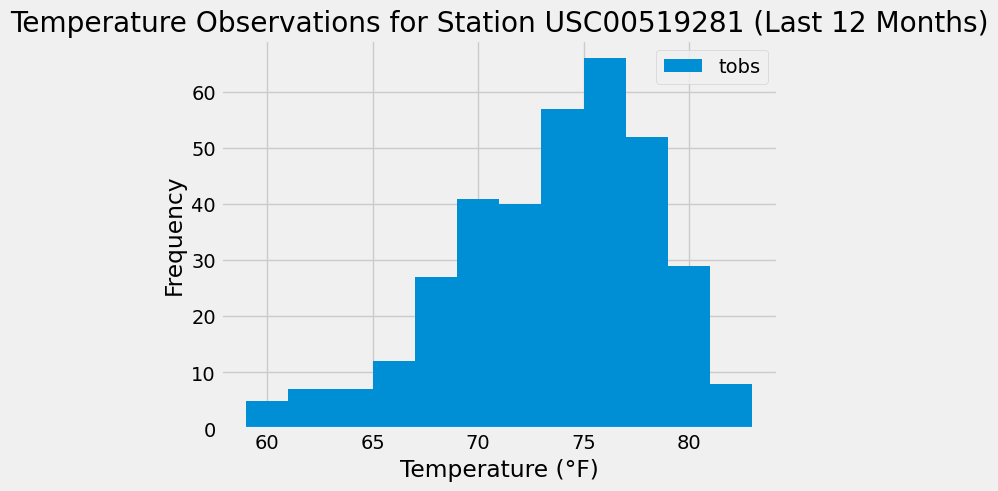

In [32]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(func.max(Measurement.date)).scalar()
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')
one_year_ago = last_date - dt.timedelta(days=365)

# Query the temperature observations for the last year for the most active station
temperature_data = (session.query(Measurement.tobs)
                    .filter(and_(Measurement.station == 'USC00519281', Measurement.date >= one_year_ago))
                    .all())

# Extract the temperatures from the query result
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for Station USC00519281 (Last 12 Months)')
plt.legend()
plt.show()

# Close Session

In [33]:
# Close Session
session.close()